In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
from comparers import ModelComparer
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import classification_report
from util import RuleClassifier, find_counterfactuals, counterfactuals_to_constraint_matrix,\
                 evaluate_counterfactual_fidelity, get_complexity
from surrogate_tree import train_surrogate_tree, tree_to_rules, plot_surrogate_tree,\
                 get_feature_importances, plot_feature_importances, plot_tree_leafs_for_class,\
                 tree_to_constraint_matrix, constraint_matrix_to_rules, extract_rules, print_rules,\
                 evaluate, search_max_depth_parameter

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
with open('ground_truth.(False, True).pickle', 'rb') as f:
    ground_truth_instance_indices_01, ground_truth_01 = pickle.load(f)
with open('ground_truth.(True, False).pickle', 'rb') as f:
    ground_truth_instance_indices_10, ground_truth_10 = pickle.load(f)

In [6]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## Find Optimal Solution

In [7]:
%%time
metrics = search_max_depth_parameter(X, mclass_diff, feature_names, comparer.difference_classes, start=2, stop=20)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

CPU times: user 800 ms, sys: 37.7 ms, total: 838 ms
Wall time: 820 ms


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


- Setting 5 will be used as the global explanation. But it's quality is very poor, because it covers only 2 of the 12 instances (17\% recall).
- Altough setting 12 is the first to have perfect recall, setting 13 will be used for generating the local explanations instead because it has the same complexity, but better precision.

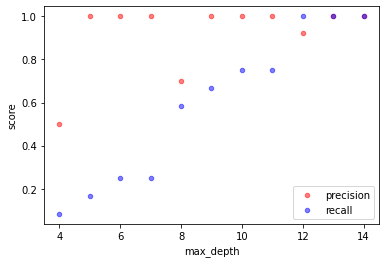

In [71]:
df = metrics.loc[metrics['label'] == 1, :].reset_index()
ax = df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5)
df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, ax=ax)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.savefig('adult-baseline-pr-curve-01.pdf')

In [14]:
metrics

,label,precision,recall,rules,constraints
4,1,0.500000,0.083333,1,4
5,1,1.000000,0.166667,2,9
6,1,1.000000,0.250000,3,13
7,1,1.000000,0.250000,3,14
8,1,0.700000,0.583333,5,28
9,1,1.000000,0.666667,6,37
10,1,1.000000,0.750000,7,44
11,1,1.000000,0.750000,7,45
12,1,0.923077,1.000000,9,66
13,1,1.000000,1.000000,9,66


## Tree with Depth 5

In [72]:
%%time
max_depth = 5
model = train_surrogate_tree(X, mclass_diff, max_depth=5)

CPU times: user 2.86 ms, sys: 1.47 ms, total: 4.33 ms
Wall time: 3.64 ms


In [73]:
evaluate(model, X, mclass_diff, comparer.class_names);

                precision    recall  f1-score   support

(False, False)       0.94      0.99      0.97       784
 (False, True)       1.00      0.17      0.29        12
  (True, True)       0.95      0.78      0.85       181

      accuracy                           0.94       977
     macro avg       0.96      0.65      0.70       977
  weighted avg       0.94      0.94      0.94       977



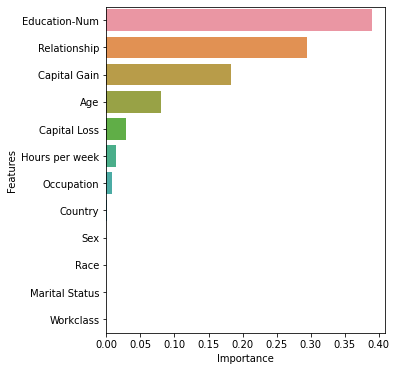

In [74]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5,6))

In [77]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)

In [78]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $\mathit{EducationNum} > 12 \land \mathit{Relationship} \leq 0 \land 5192 < \mathit{CapitalGain} \leq 7732$ [0, 1, 0]
\item $\mathit{EducationNum} > 14 \land \mathit{Relationship} \leq 4 \land \mathit{CapitalGain} \leq 5192 \land \mathit{Age} > 58$ [0, 1, 0]


### Evaluation

In [26]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(False, True)')[0]]

In [27]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(False, True)')[0]]

#### Global Fidelity

In [28]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       0.94      0.99      0.97       784
 (False, True)       1.00      0.17      0.29        12
  (True, True)       0.95      0.78      0.85       181

      accuracy                           0.94       977
     macro avg       0.96      0.65      0.70       977
  weighted avg       0.94      0.94      0.94       977



#### Counterfactual Fidelity Error

In [29]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01,
                                                      ground_truth_01, instance_indices_per_rule_01,
                                                      constraints_01)

invalid value encountered in true_divide


In [30]:
local_fidelities[(max_depth, '(False, True)')] = statistics
statistics

,RMSE,BMR,BAR
Age,NaN,1.000000,NaN
Workclass,2.000000,0.666667,0.0
Education-Num,0.500000,0.333333,0.0
Marital Status,NaN,1.000000,1.0
Occupation,NaN,1.000000,NaN
Relationship,2.500000,0.000000,0.0
Race,NaN,1.000000,NaN
Sex,NaN,1.000000,NaN
Capital Gain,3077.463417,0.000000,0.0
Capital Loss,NaN,1.000000,NaN


In [31]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
558 lower  NaN        2.0            0.5             NaN         NaN   
    upper  NaN        NaN            NaN             NaN         NaN   
531 lower  NaN        NaN            0.5             NaN         NaN   
    upper  NaN        NaN            NaN             NaN         NaN   

           Relationship  Race  Sex  Capital Gain  Capital Loss  \
558 lower           NaN   NaN  NaN       -1265.0           NaN   
    upper           0.5   NaN  NaN         658.5           NaN   
531 lower           NaN   NaN  NaN           NaN           NaN   
    upper           3.5   NaN  NaN        5136.0           NaN   

           Hours per week  Country  
558 lower             NaN      NaN  
    upper             NaN      NaN  
531 lower             NaN      NaN  
    upper             NaN      NaN

#### Complexity

In [33]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(False, True)')] = res
res

Rules          2
Constraints    9
dtype: int64

## Tree with Depth 13

In [79]:
%%time
max_depth = 13
model = train_surrogate_tree(X, mclass_diff, max_depth=max_depth)

CPU times: user 5.02 ms, sys: 9.28 ms, total: 14.3 ms
Wall time: 13.2 ms


In [80]:
evaluate(model, X, mclass_diff, comparer.class_names);

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       1.00      1.00      1.00        12
  (True, True)       1.00      1.00      1.00       181

      accuracy                           1.00       977
     macro avg       1.00      1.00      1.00       977
  weighted avg       1.00      1.00      1.00       977



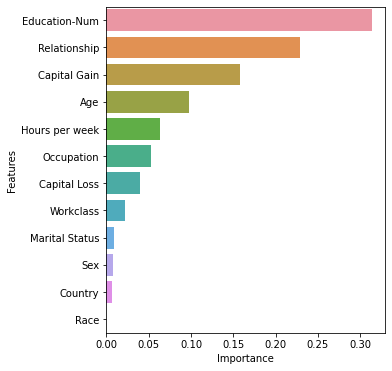

In [81]:
feature_importances, feature_order = get_feature_importances(model)
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5,6))

In [83]:
constraints, rules, class_occurences, labels, instance_indices_per_rule =\
    extract_rules(model, feature_names, comparer.difference_classes, X, mclass_diff)

In [84]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $10 < \mathit{EducationNum} \leq 12 \land \mathit{Relationship} > 4 \land \mathit{CapitalGain} \leq 5096 \land \mathit{Age} > 59 \land 38 < \mathit{Hoursperweek} \leq 42 \land \mathit{Occupation} \leq 14$ [0, 3, 0]
\item $10 < \mathit{EducationNum} \leq 12 \land \mathit{Relationship} > 4 \land \mathit{CapitalGain} \leq 5096 \land 42 < \mathit{Age} \leq 59 \land 38 < \mathit{Hoursperweek} \leq 42 \land \mathit{Occupation} \leq 4 \land 2 < \mathit{Workclass} \leq 6$ [0, 2, 0]
\item $\mathit{EducationNum} > 12 \land \mathit{Relationship} > 4 \land 36 < \mathit{Age} \leq 38 \land 31 < \mathit{Hoursperweek} \leq 50 \land \mathit{Occupation} > 4 \land \mathit{Country} > 14$ [0, 1, 0]
\item $\mathit{EducationNum} > 14 \land \mathit{Relationship} > 4 \land 27 < \mathit{Age} \leq 32 \land \mathit{Occupation} > 4$ [0, 1, 0]
\item $12 < \mathit{EducationNum} \leq 14 \land \mathit{Relationship} > 4 \land 29 < \mathit{Age} \leq 32 \land 6 < \mathit{Occupation} \leq 9$ [0, 1, 0]
\item $\mathit

### Evaluation

In [38]:
constraints_01 = [constraint for constraint, label in zip(constraints, labels) if label == comparer.check_class('(False, True)')[0]]

In [39]:
instance_indices_per_rule_01 = [instance_indices for instance_indices, label in zip(instance_indices_per_rule, labels) if label == comparer.check_class('(False, True)')[0]]

#### Global Fidelity

In [40]:
global_fidelities[max_depth] = evaluate(model, X, mclass_diff, comparer.class_names)

                precision    recall  f1-score   support

(False, False)       1.00      1.00      1.00       784
 (False, True)       1.00      1.00      1.00        12
  (True, True)       1.00      1.00      1.00       181

      accuracy                           1.00       977
     macro avg       1.00      1.00      1.00       977
  weighted avg       1.00      1.00      1.00       977



#### Counterfactual Fidelity Error

In [41]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices_01,
                                                      ground_truth_01, instance_indices_per_rule_01,
                                                      constraints_01)

invalid value encountered in true_divide


In [42]:
local_fidelities[(max_depth, '(False, True)')] = statistics
statistics

,RMSE,BMR,BAR
Age,9.415560,0.250000,0.0
Workclass,1.752549,0.666667,0.0
Education-Num,0.540062,0.217391,0.0
Marital Status,2.000000,0.923077,0.0
Occupation,5.602353,0.521739,0.0
Relationship,1.118034,0.368421,0.0
Race,NaN,1.000000,NaN
Sex,NaN,1.000000,NaN
Capital Gain,4139.112375,0.230769,0.0
Capital Loss,1048.500000,0.833333,0.0


In [43]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
701 lower  24.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN        10.5   
948 lower  15.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN        10.5   
961 lower  -2.0        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            0.5             NaN         9.5   
64  lower  -1.5        1.5            0.5             NaN         NaN   
    upper  -2.0        0.5            0.5             NaN         0.5   
406 lower  -1.5        1.5            0.5             NaN         NaN   
    upper  -2.0        0.5            0.5             NaN         0.5   
70  lower   3.5        NaN            0.5             NaN         1.5   
    upper  -1.5        NaN            1.0             NaN         NaN   
883 lower   0.0        NaN            0.5             NaN        -5.5   
    upper   2.5        NaN            NaN             NaN         NaN   
925 lower  -2.0        NaN            0.5             NaN        -0.5   
    upper  -1.5        NaN           -0.5             NaN         0.0   
484 lower   3.5        3.5            NaN             NaN         NaN   
    upper -10.5        NaN            0.5             NaN         NaN   
744 lower   3.5        NaN            NaN             NaN         0.5   
    upper -10.5       -0.5            0.5             NaN         1.0   
558 lower   NaN        2.0            NaN             2.0         NaN   
    upper   NaN        NaN            NaN             NaN         NaN   
531 lower  22.5        NaN            0.5             NaN         NaN   
    upper   NaN        NaN            NaN             NaN         NaN   

           Relationship  Race  Sex  Capital Gain  Capital Loss  \
701 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
948 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
961 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
64  lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
406 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        5039.5           NaN   
70  lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
883 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
925 lower          -0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN           NaN           NaN   
484 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        2822.0        1048.5   
744 lower           0.5   NaN  NaN           NaN           NaN   
    upper           NaN   NaN  NaN        2822.0        1048.5   
558 lower           NaN   NaN  NaN       -1265.0           NaN   
    upper           0.5   NaN  NaN         658.5           NaN   
531 lower           NaN   NaN  NaN           NaN           NaN   
    upper           3.5   NaN  NaN        5136.0           NaN   

           Hours per week  Country  
701 lower            -1.5      NaN  
    upper             1.5      NaN  
948 lower            -1.5      NaN  
    upper             1.5      NaN  
961 lower            -1.5      NaN  
    upper             1.5      NaN  
64  lower            -1.5      NaN  
    upper             0.5      NaN  
406 lower            -1.5      NaN  
    upper             0.5      NaN  
70  lower            -8.0      NaN  
    upper             NaN      NaN  
883 lower             NaN      NaN  
    upper        

#### Complexity

In [44]:
res = get_complexity(constraints_01)
complexities[(max_depth, '(False, True)')] = res
res

Rules           9
Constraints    67
dtype: int64

# Summary

In [46]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 5:
        level = 'global'
    elif depth == 13:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [47]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[np.in1d(global_fidelity.index.get_level_values('class'), comparer.difference_class_names)]
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision    Recall  F1 Score  Support
class         depth                                        
(False, True) 5            1.0  0.166667  0.285714       12
              13           1.0  1.000000  1.000000       12

## Local Fidelity

In [48]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR  BAR
class         depth feature                                   
(False, True) 5     Age                     NaN  1.000000  NaN
                    Capital Gain    3077.463417  0.000000  0.0
                    Capital Loss            NaN  1.000000  NaN
                    Country                 NaN  1.000000  NaN
                    Education-Num      0.500000  0.333333  0.0
                    Hours per week          NaN  1.000000  NaN
                    Marital Status          NaN  1.000000  1.0
                    Occupation              NaN  1.000000  NaN
                    Race                    NaN  1.000000  NaN
                    Relationship       2.500000  0.000000  0.0
                    Sex                     NaN  1.000000  NaN
                    Workclass          2.000000  0.666667  0.0
              13    Age                9.415560  0.250000  0.0
                    Capital Gain    4139.112375  0.230769  0.0
                    Capital Loss    1048.500000  0.833333  0.0
                    Country                 NaN  1.000000  1.0
                    Education-Num      0.540062  0.217391  0.0
                    Hours per week     4.994640  0.416667  0.0
                    Marital Status     2.000000  0.923077  0.0
                    Occupation         5.602353  0.521739  0.0
                    Race                    NaN  1.000000  NaN
                    Relationship       1.118034  0.368421  0.0
                    Sex                     NaN  1.000000  NaN
                    Workclass          1.752549  0.666667  0.0

## Complexity

In [49]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class         depth                    
(False, True) 5          2            9
              13         9           67

## Generation Time

<1s

In [50]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.baseline.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)